# Example of variational quantum eigensolver

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from tools import Circuit, gate_dic
from state_vector_qpu import State, StateVectorQPU


In [2]:
from copy import deepcopy

def compute_energy(H, res):
    """computing <psi|H|psi>
    
    Args:
        H (list): list [(lambda_i, P_i)] with P_i = list [(X, 0), (Y, 1), ...]
        psi (State): final state of circuit
        
    Returns:
        <psi|H|psi>
    """
    val = 0.0
    for coeff, term in H:
        res_copy = deepcopy(res)
        for pauli, qb in term:
            res_copy.apply(gate_dic[pauli], [qb])
        val += coeff * res.to_vec().conj().dot(res_copy.to_vec())
        
    return val
 
# test on Bell state
circ = Circuit(2, [("H", [0]), ("CNOT", [0, 1])])

qpu = StateVectorQPU(2, gate_dic)
res = qpu.submit(circ)

print(res)

H = [(1., [("Z", 0), ("Z", 1)])] # ZZ measurement
energy = compute_energy(H, res)
print("<ZZ> =", energy)

H = [(1., [("Z", 0)])] # Z measurement

type(res)
energy = compute_energy(H, res)
print("<Z> =", energy)

|00> : (0.7071067811865475+0j) 
|01> : 0j 
|10> : 0j 
|11> : (0.7071067811865475+0j) 

<ZZ> = (0.9999999999999998+0j)
<Z> = (-2.2371143170757382e-17+0j)


In [3]:
# "hardware-efficient ansatz"
def make_ansatz(theta):
    n_layers = 3
    n_qbits = len(theta) // n_layers
    gate_list = []
    for ind in range(n_layers):
        for qb in range(n_qbits):
            gate_list.append(("RY", [qb], theta[ind*n_qbits+ qb]))
        for qb in range(n_qbits-1):
            gate_list.append(("CNOT", [qb, qb+1]))
    circ = Circuit(n_qbits, gate_list)
    return circ

    
def get_energy(theta, record=True):
    global energy_list
    n_layers = 3
    n_qbits = len(theta) // n_layers
    qpu = StateVectorQPU(n_qbits, gate_dic)
    circ = make_ansatz(theta)
    res = qpu.submit(circ)
    energy = compute_energy(H, res)
    
    # keeping track of values encountered during optimization
    if record:
        energy_list.append(energy)
    return energy

def get_gradient(theta):
    # computing the gradient with the parameter-shift rule
    grad = []
    for k in range(len(theta)):
        e_plus_pi_h = get_energy([t+np.pi/2 if ind==k else t for ind, t in enumerate(theta)], False)
        e_minus_pi_h = get_energy([t-np.pi/2 if ind==k else t for ind, t in enumerate(theta)], False)
        grad.append(0.5*(e_plus_pi_h-e_minus_pi_h))
    
    return grad
# test on Heisenberg model

n_sites = 3
H = [(1, [("Z", i), ("Z", (i+1)%n_sites)]) for i in range(n_sites)]
H += [(1, [("X", i), ("X", (i+1)%n_sites)]) for i in range(n_sites)]
H += [(1, [("Y", i), ("Y", (i+1)%n_sites)]) for i in range(n_sites)]

# simple test
theta = np.random.rand(n_sites*3)
energy_list = []
en = get_energy(theta)

# now do optimization
from scipy.optimize import minimize
energy_list = []

result = minimize(get_energy, x0 = theta, method="CG")
print(result)

/usr/local/lib64/python3.9/site-packages/scipy/optimize/_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/usr/local/lib64/python3.9/site-packages/scipy/optimize/_linesearch.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -2.999999999986783
       x: [ 3.045e+00 -5.037e+00  1.142e+00  3.215e+00 -6.484e+00
            1.348e+00 -1.544e+00  6.116e-02  6.761e+00]
     nit: 23
     jac: [-6.855e-07  2.831e-06  1.490e-07 -1.162e-06 -8.941e-07
           -3.666e-06  9.537e-07 -1.460e-06 -8.345e-07]
    nfev: 430
    njev: 43


### Optimization trace

/usr/local/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


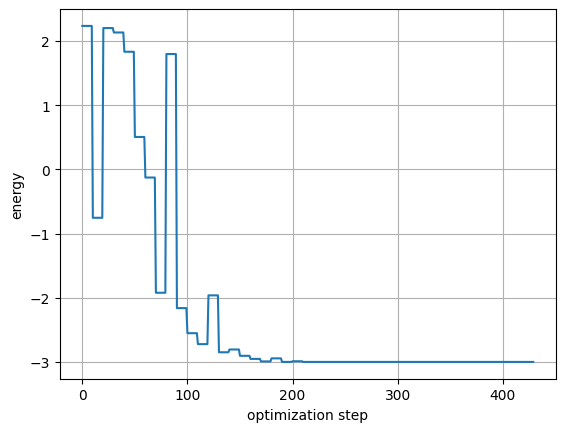

In [4]:
import matplotlib.pyplot as plt
plt.plot(energy_list)
plt.ylabel("energy")
plt.xlabel("optimization step")
plt.grid();

## With an explicit gradient

In [5]:
# now do optimization
from scipy.optimize import minimize
energy_list = []

result = minimize(get_energy, x0 = theta, method="CG", jac=get_gradient)
print(result)

/usr/local/lib64/python3.9/site-packages/scipy/optimize/_differentiable_functions.py:243: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -2.999999999980333
       x: [ 3.04512177+0.j -5.03666326+0.j  1.14275449+0.j  3.21538396+0.j
           -6.48354959+0.j  1.34826013+0.j -1.5439479 +0.j  0.06106688+0.j
            6.76104779+0.j]
     nit: 24
     jac: [ 3.40314526e-06+0.j -2.41738769e-06+0.j -3.52061596e-06+0.j
            2.64517378e-06+0.j  2.75700199e-06+0.j  2.84608790e-08+0.j
            4.78463575e-06+0.j -2.89476197e-06+0.j -3.51157666e-06+0.j]
    nfev: 43
    njev: 43


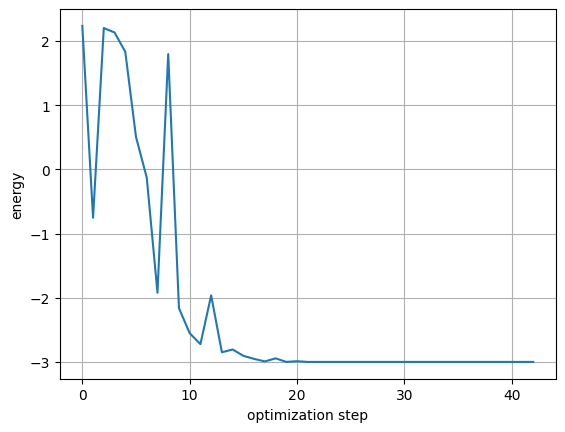

In [6]:
import matplotlib.pyplot as plt
plt.plot(energy_list)
plt.ylabel("energy")
plt.xlabel("optimization step")
plt.grid();

See how fast the convergence is!